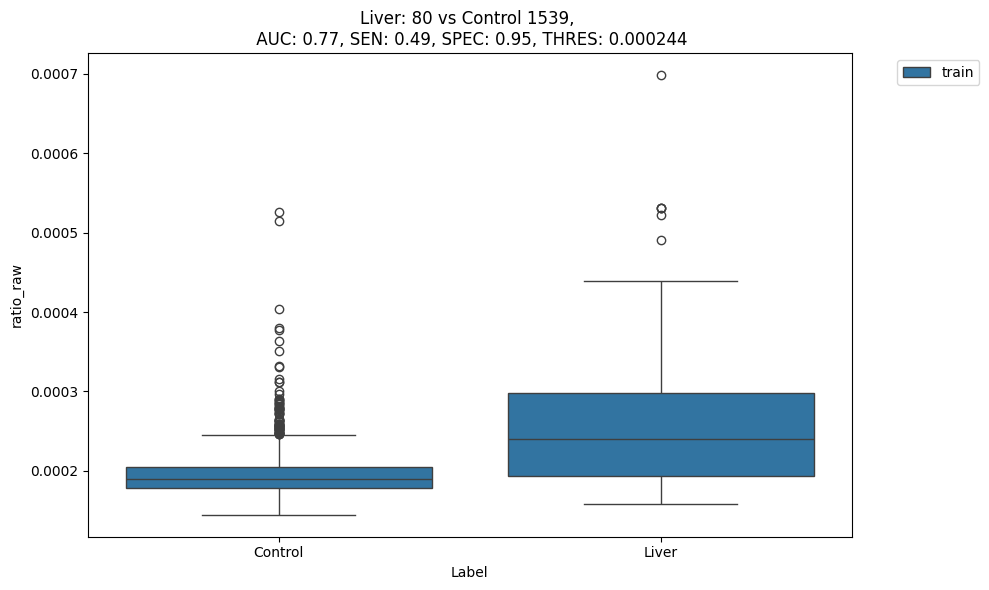

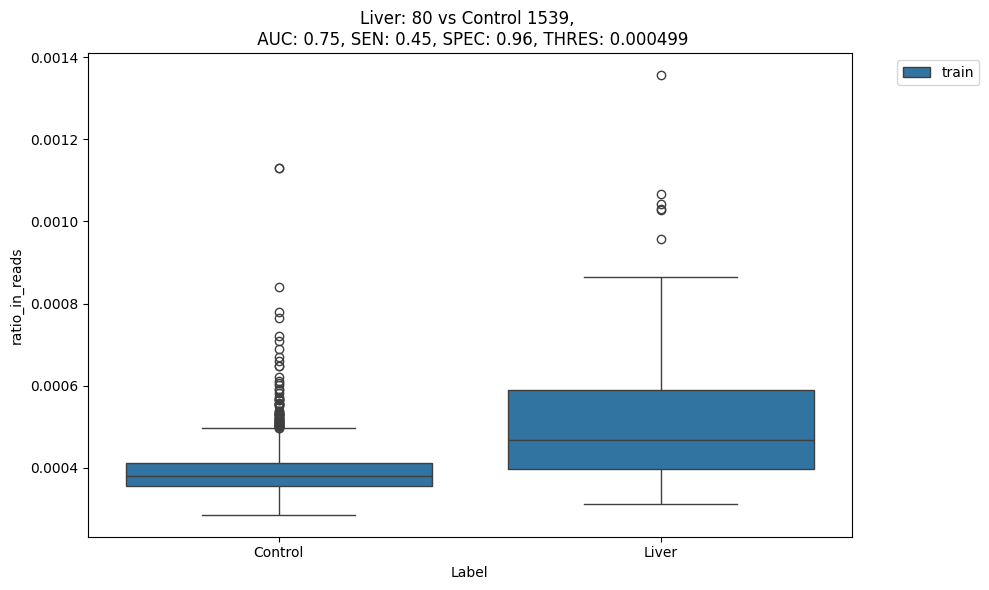

0.000244168405598261
0.0004987937725601575


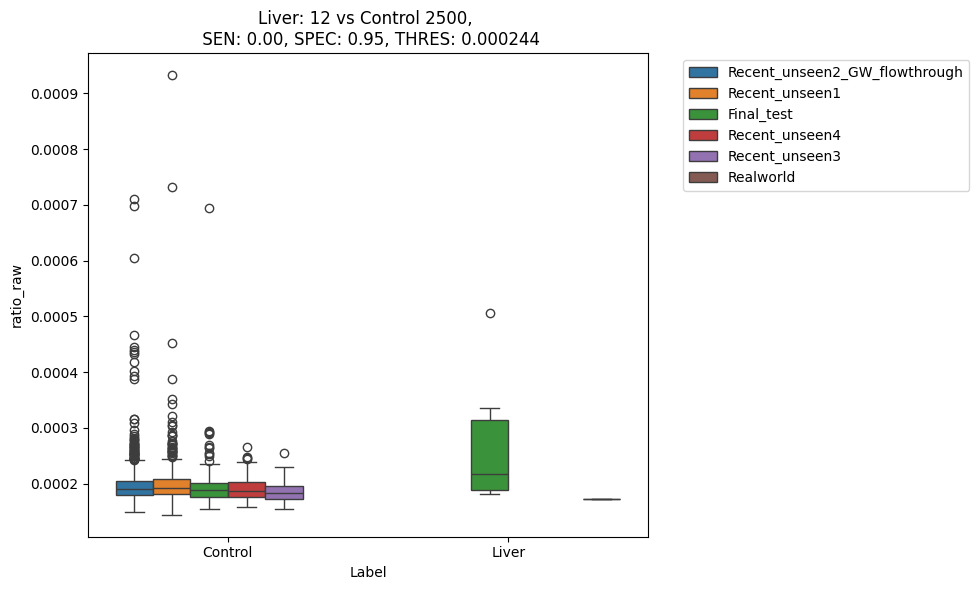

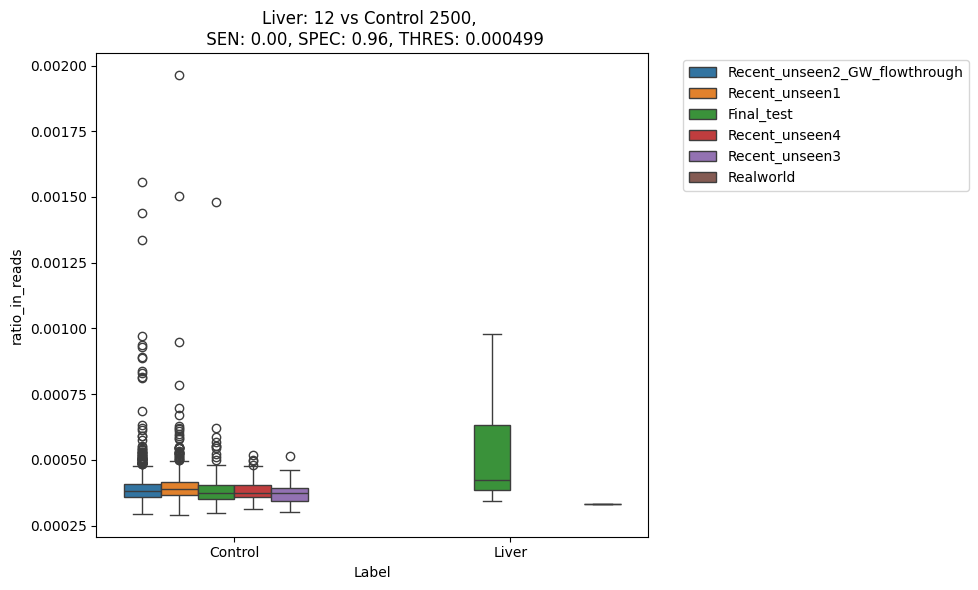

In [ ]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/HNSD_mini/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

for mode in ["all", "hypo_only", "hyper_only"]:
    # input_cancer_class = "Gastric"
    all_cancer_classes = ["Liver", "Lung", "Breast", "CRC"]
    all_selected_thres_ratio_raw = []
    all_selected_thres_ratio_in_reads = []

    for input_cancer_class in all_cancer_classes:
        path_to_main_output = os.path.join(outdir, PROJECT, output_version)
        if mode == "all":
            path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        elif mode == "hypo_only":
            path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        elif mode == "hyper_only":
            path_to_07_output = os.path.join(outdir, PROJECT, output_version, "07_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_08_output = os.path.join(outdir, PROJECT, output_version, "08_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        os.system(f"mkdir -p {path_to_08_output}")

        metadata = pd.read_excel("metadata_cfDNA_lowpdepth_TMD_bam_cov.xlsx")
        metadata = metadata[metadata["Label"].isin([input_cancer_class, "Control"])]

        all_files = [item for item in pathlib.Path(path_to_07_output).glob("*.candi_reads.csv")]
        countdf = pd.read_csv(os.path.join(path_to_07_output, "all_count.csv"), index_col = [0])

        all_samples = []
        all_mean_candi_reads = []
        for file in all_files:
            tmpdf = pd.read_csv(file)
            mean_candi_reads = tmpdf.candi_reads.mean()
            all_samples.append(file.name.split(".")[0])
            all_mean_candi_reads.append(mean_candi_reads)

        candidf = pd.DataFrame({"SampleID": all_samples, "num_candi_reads": all_mean_candi_reads})
        candidf = candidf.merge(countdf, right_on = "SampleID", left_on = "SampleID")
        candidf["ratio_raw"] = candidf["num_candi_reads"] / candidf["raw_count"]
        candidf["ratio_in_reads"] = candidf["num_candi_reads"] / candidf["in_read_count"]
        candidf = candidf.merge(metadata[["SampleID", "Label", "Set"]], right_on = "SampleID", left_on = "SampleID")
        candidf.to_excel(os.path.join(path_to_08_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)), index = False)

        candidf = candidf.fillna(0)

        #####-------------------------------------------------------------#####
        ##### summary model metrics on training set.
        #####-------------------------------------------------------------#####
        candidf_train = candidf[candidf["Set"] == "train"].copy()
        candidf_test = candidf[candidf["Set"] != "train"].copy()

        # Calculate the ROC curve for the values ratio_raw
        def plot_roc_curve(inputdf, figname1, figname2, selected_thres_ratio_raw = None, selected_thres_ratio_in_reads = None):
            fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(inputdf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), inputdf['ratio_raw'])
            num_cancer = inputdf[inputdf["Label"] == input_cancer_class].shape[0]
            num_control = inputdf[inputdf["Label"] != input_cancer_class].shape[0]

            if (selected_thres_ratio_raw is None) or (selected_thres_ratio_in_reads is None):
                aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
                aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

                selected_thres_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
                selected_spec_ratio_raw = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
                selected_sens_ratio_raw = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

                # Calculate the AUC
                roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
                title_raw = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_raw:.2f}, SPEC: {selected_spec_ratio_raw:.2f}, THRES: {selected_thres_ratio_raw:.6f}"

                # Calculate the ROC curve for the values ratio_in_reads
                fpr_ratio_in_reads, tpr_ratio_in_reads, thres_ratio_in_reads = roc_curve(inputdf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), inputdf['ratio_in_reads'])
                aucdf = pd.DataFrame({"fpr": fpr_ratio_in_reads, "tpr": tpr_ratio_in_reads, "thres": thres_ratio_in_reads})
                aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

                selected_thres_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
                selected_spec_ratio_in_reads = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
                selected_sens_ratio_in_reads = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

                # Calculate the AUC
                roc_auc = auc(fpr_ratio_in_reads, tpr_ratio_in_reads)
                title_in_reads = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n AUC: {roc_auc:.2f}, SEN: {selected_sens_ratio_in_reads:.2f}, SPEC: {selected_spec_ratio_in_reads:.2f}, THRES: {selected_thres_ratio_in_reads:.6f}"
                
            else:
                inputdf["prediction_raw"] = inputdf["ratio_raw"].apply(lambda x: 1 if x >= selected_thres_ratio_raw else 0)
                inputdf["prediction_in_reads"] = inputdf["ratio_in_reads"].apply(lambda x: 1 if x >= selected_thres_ratio_in_reads else 0)
                
                SEN_raw = inputdf[(inputdf["prediction_raw"] == 1) & (inputdf["Label"] == input_cancer_class)].shape[0]/inputdf.shape[0]
                SPEC_raw = inputdf[(inputdf["prediction_raw"] == 0) & (inputdf["Label"] != input_cancer_class)].shape[0]/inputdf.shape[0]

                SEN_in_reads = inputdf[(inputdf["prediction_in_reads"] == 1) & (inputdf["Label"] == input_cancer_class)].shape[0]/inputdf.shape[0]
                SPEC_in_reads = inputdf[(inputdf["prediction_in_reads"] == 0) & (inputdf["Label"] != input_cancer_class)].shape[0]/inputdf.shape[0]

                title_raw = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n SEN: {SEN_raw:.2f}, SPEC: {SPEC_raw:.2f}, THRES: {selected_thres_ratio_raw:.6f}"
                title_in_reads = f"{input_cancer_class}: {num_cancer} vs Control {num_control}, \n SEN: {SEN_in_reads:.2f}, SPEC: {SPEC_in_reads:.2f}, THRES: {selected_thres_ratio_in_reads:.6f}"

            plt.figure(figsize=(10, 6))
            sns.boxplot(data=inputdf, x="Label", y="ratio_raw", hue="Set")
            plt.title(title_raw)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_08_output, figname1), format='svg')
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.boxplot(data=inputdf, x="Label", y="ratio_in_reads", hue="Set")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(title_in_reads)
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_08_output, figname2), format='svg')
            plt.show()
            
            return selected_thres_ratio_raw, selected_thres_ratio_in_reads
            
        selected_thres_ratio_raw, selected_thres_ratio_in_reads = plot_roc_curve(candidf_train, "boxplot_ratio_candi_to_raw_counts.train.svg", "boxplot_ratio_candi_to_inside_read_counts.train.svg")
        print(selected_thres_ratio_raw)
        print(selected_thres_ratio_in_reads)
        plot_roc_curve(candidf_test, "boxplot_ratio_candi_to_raw_counts.test.svg", "boxplot_ratio_candi_to_inside_read_counts.test.svg", selected_thres_ratio_raw, selected_thres_ratio_in_reads)
        all_selected_thres_ratio_raw.append(selected_thres_ratio_raw)
        all_selected_thres_ratio_in_reads.append(selected_thres_ratio_in_reads)

    thresdf = pd.DataFrame(
        {
            "cancer_class": all_cancer_classes,
            "ratio_raw": all_selected_thres_ratio_raw,
            "ratio_in_reads": all_selected_thres_ratio_in_reads 
        }
    )
    thresdf.to_csv(f"thresdf.{mode}.csv", index = False)